In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import tree

# Get and prepare data

In [2]:
"""file and folder change into your specific path. Contains dataset"""

LC = ["AT", "BE", "NL", "DE", "UK","EL", "EE","DK", "CZ", "CY", "BG", "FI", "FR", "HR", "HU","IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO","SE", "SI", "SK"]
file = r'C:/Users/User/Documents/LUCAS2015_topsoildata_20200323/LUCAS_Topsoil_2015_20200323.csv'
folder = r"C:/Users/User/Documents/LUCAS2015_spectra/LUCAS2015_Soil_Spectra_EU28/spectra_ "

In [8]:
"""    
Reads all csv files of the LUCAS 2015 dataset. Reads the reflectance
values and OC values of all given location points and gets put in a pandas dataframe.
"""
result = pd.DataFrame()
spec = pd.read_csv(file)

for c in LC:
    df = pd.read_csv(folder + c + " .csv")
    columns = df.columns[5:]
    columns = columns.insert(0, 'PointID')
    left = df[columns]
    right = spec[['Point_ID', 'OC']]
    right = right.rename(columns={'Point_ID': 'PointID'})
    r = pd.merge(left, right, on="PointID")
    result = pd.concat([result, r], axis=0)

In [9]:
"""Remove all strong outliers of the OC values in the dataset."""
Q1 = result['OC'].quantile(0.25)
Q3 = result['OC'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
# comment voor 1e versie model
result = result[result['OC'] < Q3 + IQR * 1.5]
result = result[result['OC'] > Q1 - IQR * 1.5]
U_result = result.reset_index()

13.5 41.3 27.799999999999997


In [10]:
U_result

,index,PointID,400,400.5,401,401.5,402,402.5,403,403.5,...,2495.5,2496,2496.5,2497,2497.5,2498,2498.5,2499,2499.5,OC
0,0,46442722,0.901924,0.907745,0.913509,0.919191,0.924762,0.930197,0.935479,0.940585,...,0.681045,0.681039,0.681024,0.681001,0.680971,0.680936,0.680897,0.680853,0.680794,36.3
1,1,46442722,0.898363,0.904257,0.910094,0.915846,0.921486,0.926987,0.932330,0.937492,...,0.677963,0.677970,0.677974,0.677974,0.677971,0.677963,0.677951,0.677934,0.677908,36.3
2,2,46522722,0.870422,0.876326,0.882174,0.887940,0.893597,0.899119,0.904488,0.909685,...,0.604487,0.604457,0.604425,0.604390,0.604355,0.604319,0.604284,0.604248,0.604204,42.6
3,3,46522722,0.869277,0.875201,0.881073,0.886863,0.892548,0.898098,0.903495,0.908716,...,0.602782,0.602775,0.602761,0.602740,0.602711,0.602675,0.602634,0.602588,0.602525,42.6
4,4,46882726,0.937757,0.944273,0.950737,0.957122,0.963402,0.969554,0.975558,0.981393,...,0.660686,0.660632,0.660573,0.660508,0.660440,0.660369,0.660294,0.660218,0.660117,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31632,451,48482874,0.804873,0.812589,0.820333,0.828019,0.835624,0.843117,0.850475,0.857677,...,0.458666,0.458778,0.458881,0.458979,0.459073,0.459165,0.459258,0.459354,0.459489,17.1
31633,452,50722882,0.713708,0.721776,0.729873,0.737912,0.745862,0.753694,0.761384,0.768904,...,0.472882,0.472955,0.473020,0.473078,0.473132,0.473184,0.473235,0.473287,0.473360,50.3
31634,453,50722882,0.714726,0.722801,0.730902,0.738935,0.746873,0.754686,0.762347,0.769831,...,0.474116,0.474202,0.474273,0.474331,0.474379,0.474419,0.474455,0.474490,0.474539,50.3
31635,454,51822906,0.721657,0.728295,0.734950,0.741537,0.748024,0.754379,0.760583,0.766609,...,0.582359,0.582545,0.582723,0.582896,0.583068,0.583241,0.583418,0.583600,0.583855,24.1


In [11]:
U_result['OC'].describe()

count    31637.000000
mean        24.918257
std         16.667604
min          0.100000
25%         12.800000
50%         19.600000
75%         32.400000
max         82.900000
Name: OC, dtype: float64

In [12]:
"""Seperate the dataset into its label (y) and input data (X), and 
split the data into train and test data, the test data is test_size% of the entire dataset."""
X = U_result[U_result.columns[2:-1]].values
y = U_result[U_result.columns[-1]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state=3)


## Linear Regression

In [13]:
"""The linear regression model, build and fitted. Here the
results also get printed."""
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(model.score(X_test, y_test))

9.782295407893011
0.649441729478961


## Decision tree regressor

In [14]:
"""The decision tree model, build and fitted. Here the
results also get printed."""
DT = tree.DecisionTreeRegressor()
DT.fit(X_train, y_train)
y_predDT = DT.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_predDT)))
print(DT.score(X_test, y_test))

12.707109013029934
0.4084762563118628


In [15]:
"""Get model characteristics"""
print(DT.get_n_leaves())
print(DT.get_depth())
print(DT.get_params())

18473
34
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


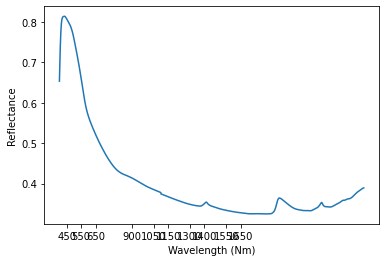

In [16]:
plt.xlabel('Wavelength (Nm)')
plt.ylabel('Reflectance')
plt.xticks([100, 300, 500, 1000, 1300, 1500, 1800, 2000, 2300, 2500])

plt.plot(result.columns[1:-1], U_result.loc[22426][2:-1].values)